# Introdução

Grupo formado por:

- **Murilo Henrique Scarmagnani Pimenta** - N° USP 11233115

- **Arthur Yassine Oliveira** - N° USP 11299853

- **Felipe Vinicius Silva** - N° USP 11279603

- **Marcos Vinícius Teixeira Silva** - N° USP 11233028

- **Lucas Bueno Teixeira** - N° USP 11233011

Objetiva-se realizar o **enunciado 1** do trabalho, de modo a calcular a missão de uma aeronave EMB-120 "Brasília" levando em consideração sua subida e voo em cruzeiro decolando do aeroporto de Leh (código IATA "IXL"), na Índia. Rotina computacional baseada em ADRpy - Aircraft Design Recipes for Python -, disponível na [documentação](https://adrpy.readthedocs.io/en/latest/#) da biblioteca. 

# Preparação

Importação de bibliotecas

In [ ]:
!pip install ADRpy

import numpy as np
import matplotlib.pyplot as plt
from ADRpy import atmospheres as at
from ADRpy import unitconversions as co

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Voo ascendente

Para voo ascendente, estuda-se a etapa de subida da aeronave. O tempo dessa fase é dividido em parcelas iguais de modo que, a todo instante, é calculado o consumo de combustível da aeronave para que o peso consumido seja descontado da aeronave no próximo instante, além da atualização das condições atmosféricas. Com isso, calcula-se a distância percorrida pela aeronave bem como o tempo gasto nessa fase para uma dada razão de subida.

Nessa seção, considera-se que o voo ascendente é realizado em apenas uma etapa (**1 step climb**) e que essa etapa é feita com **velocidade constante** e **ângulo de subida constante**, ou seja, considera-se que a aeronave saiu do segmento 4° da decolagem e está em configuração de subida. Nesse âmbito, é considerado que os **flapes estão recolhidos**, bem como o **trem de pouso**. Considera-se todos os **motores funcionais** e **ausência de gelo** no bordo de ataque.

Com isso, a aeronave inicia o processo de subida em **1500ft** (fim do segmento 4) e sobe até próximo de seu teto de serviço, em **29500ft**. Nesse trajeto, adota-se a **condição de máxima razão de subida**, pois assim a economia de combustível dos motores à combustão é máxima e, portanto, atinge-se o maior alcance possível da aeronave. Nessa condição, tem-se que:

\begin{equation}
  max\left(\frac{C_L}{C_D}\right) \implies C_L = \sqrt{\frac{C_{D0}}{k}}\hspace{0.5cm}, \hspace{0.5cm} C_D = 2C_{D0}
\end{equation}

Onde as polares fornecidas com o enunciado apontam $C_{D0} = 0.032$ e $k = 0.021$. Com os coeficientes aerodinâmicos $C_L$ e $C_D$ definidos pelas relações acimma, utiliza-se a relação de equilíbrio $L=Wcos\gamma$ que, para ângulo de trajetória muito pequeno, resulta em $L=W$ e permite que a velocidade seja calculada como:

\begin{equation}
  V = \sqrt{\frac{2W}{S_w \rho C_L}}
\end{equation}

Onde o peso é dado por $W = 112815N$ (condição de MTOW), a área de asa é dada por $S_w = 39.4m^2$ e a densidade $\rho$ depende da condição atmosférica momentânea. Em posse da velocidade, calcula-se o ângulo de subida como sendo:

\begin{equation}
  \gamma = \frac{T-D}{W}
\end{equation}

Em que a tração dos $n$ motores é dada por:

\begin{equation}
  T = \frac{Pn}{V}\eta_{p}
\end{equation}

onde a eficiência da hélice $\eta_p = -0.1305C_L^2 + 0.8046$.

Além disso, a razão de subida é dada por:

\begin{equation}
  \dot{h} = V\gamma
\end{equation}

Em posse do valor de razão de subida, considera-se que a aeronave subiu uma altitude equivalente a 

\begin{equation}
  \Delta h = \dot{h}  \Delta t
\end{equation}

Por fim, a aeronave sofre um decréscimo de peso devido à queima de combustível, tal que:

\begin{equation}
  \Delta W = - P n \Delta T \hat{c} g
\end{equation}

que para o motor PW118, $\hat{c} = 303 g/kWh$.

Nessa nova altitude, calcula-se a densidade do ar, recalcula-se a velocidade de subida, ângulo de subida, tração, peso da aeronave e a nova razão de subida, repetindo o ciclo até chegar na altitude desejada.

Por fim, a aeronave em cada passo de subida $\Delta h$ se deslocou horizontalmente numa distância dada por

\begin{equation}
  \Delta x = \frac{\dot{h}\Delta t}{\gamma}   
\end{equation}

que será somada a cada passo a fim de descobrir o deslocamento da aeronave durante toda a etapa de subida.


In [ ]:
"""
calculate_eta: função para cálculo da eficiência da hélice

INPUTS:
  - cl (float): coeficiente aerodinâmico de sustentação [-]

OUTPUTS:
  - eta_p (float): eficiência propulsiva do GMP [-]
"""

def calculate_eta(cl):
  eta_p = -0.1305 * cl**2 + 0.8046
  return eta_p



"""
calculate_max_climb: função para cálculo de máxima razão de subida

INPUTS:
  - cd0 (float): coeficiente linear da polar de arrasto [-]
  - k (float): coeficiente angular da polar de arrasto [-]
  - W (float): Peso da aeronave [N]
  - Sw (float): área de asa da aeronave [m^2]
  - rho (float): densidade local do ar [kg/m^3]
  - num_motors (integer): número de motores operantes [-]
  - power_each (float): potência máxima de cada motor [W]

OUTPUTS:
  - h_ponto (float): máxima razão de subida [m/s]
  - gamma (float): ângulo de subida [rad]
"""

def calculate_max_climb(cd0, k, W, Sw, rho, num_motors, power_each):

  #cálculo da velocidade para máxima razão de subida
  cl = np.sqrt(1 * cd0 / k)
  cd = 2 * cd0
  v = np.sqrt( 2 * W /  (Sw * rho * cl) )

  #cálculo da tração total desenvolvida
  eta = calculate_eta(cl)
  T = power_each * num_motors / v * eta
  
  #cálculo das potência necessária e disponível
  D = 1 / 2 * rho * v**2 * Sw * cd
  needed_power = D * v
  available_power = T * v

  #cálculo do ângulo de subida
  gamma = (T - D) / W

  #cálculo da razão de subida
  h_ponto = v * gamma

  return h_ponto, gamma, v

"""
voo_ascendente: função que calcula alcance para voo ascendente

INPUTS:
  - h_initial (float): altura inicial da aeronave [ft]
  - h_goal (float): altura final da aeronave [ft]
  - delta_t (int): passo de tempo da discretização [s]
  - delta_ISA (int): offset de temperatura da atmosfera padrão ISA [°C]
  - W (float): peso da aeronave [N]

OUTPUTS:
  - res_h (numpy array): vetor com as alturas de cada instante [ft]
  - res_x (numpy array): vetor com a posição em X de cada instante [m]
  - res_t (numpy array): vetor com o tempo de cada instante [s]
  - res_h_ponto (numpy array): vetor com a razão de subida de cada instante [m/s]
  - res_gamma (numpy array): vetor com o ângulo de subida de cada instante [rad]
  - res_w (numpy array): vetor com o peso da aeronave a cada instante [N]
"""

def voo_ascendente(h_initial, h_goal, delta_t, delta_ISA, W):
  #inicialização das variáveis de altura, alcance e tempo
  h = h_initial #ft
  x = 0 #m
  t = 0 #s

  #inicialização da atmosfera
  isa = at.Atmosphere(offset_deg = delta_ISA)
  altitude_m = co.feet2m(h) #converte para metros
  rho = isa.airdens_kgpm3(altitude_m) #densidade inicial 

  #inicialização dos vetores de resultado
  res_h = []
  res_x = []
  res_t = []
  res_h_ponto = []
  res_gamma = []
  res_w = []

  #loop de altura e redução de peso por cada delta t
  while h_goal > h:
    h_ponto, gamma, v = calculate_max_climb(cd0, k, W, Sw, rho, num_motors, power_each)
    h += co.m2feet(h_ponto)*delta_t
    x += h_ponto*delta_t/gamma
    t += delta_t
    W -= num_motors * power_each * delta_t * 303 / (3.6 * 10 ** 9) * 9.81
    altitude_m = co.feet2m(h)
    rho = isa.airdens_kgpm3(altitude_m)

    #guardar resultados
    res_h = np.append(res_h, h)
    res_x = np.append(res_x, x)
    res_t = np.append(res_t, t)
    res_h_ponto = np.append(res_h_ponto, h_ponto)
    res_gamma = np.append(res_gamma, gamma)
    res_w = np.append(res_w, W)
  
  return res_h, res_x, res_t, res_h_ponto, res_gamma, res_w

# Voo em cruzeiro

Para considerações de voo de cruzeiro, escolheu-se a condição de velocidade requisitada pelo enunciado dada pela condição da *max range*, que por sua vez vale $V_{cruz} = 155 m/s$.

O peso da aeronave varia a cada instante e a densidade depende da altitude escolhida. Por simplificação, assume-se que toda a etapa de cruzeiro da aeronave se dá em seu teto de voo a **29500ft** e assim a densidade pode ser assumida como constante. Além disso, é necessário considerar reservas NBAA para 45 minutos de *hold* em velocidade de cruzeiro.

Com isso, a lógica é atualizar a cada instante o peso da aeronave. Quando o máximo alcance ($1750 - X_{sub}$) for atingido , onde $X_{sub}$ é a distância percorrida na subida, a aeronave deve conseguir manter altitude de cruzeiro ainda por 45 minutos. Para isso, será verificado o percentual de combustível da aeronave, que não poderá ser zerado em nenhum momento da missão.

O peso de combustível é dado por

\begin{equation}
  W_{fuel} = V_{f} \rho_{f} g
\end{equation}

onde o volume máximo comportado é de $V_f=3340L$, a densidade média é de $\rho_f = 0.8kg/L$, totalizando $W_{fuel} = 26200N$. Também leva-se em conta o combustível gasto para subida da aeronave.

In [ ]:
"""
voo_cruzeiro: função que calcula alcance para voo em cruzeiro

INPUTS:
  - h (float): altura inicial da aeronave [ft]
  - x_goal(float): alcance máximo desejado [m]
  - x (float): alcance inicial da aeronave após subida [m]
  - w_total (float): MTOW da aeronave [N]
  - w (float): peso da aeronave no início de cruzeiro [N]
  - w_fuel_total (float): peso de combustível embarcado [N]
  - delta_t (int): passo de discretização de tempo [s]
  - num_motors (int): número de motores na aeronave [-]
  - power_each (float): potência de cada motor [W]
  - v (float): velocidade de cruzeiro [m/s]

OUTPUTS:
  - res_x_cruz (numpy array): vetor com a posição em X de cada instante [m]
  - res_t_cruz (numpy array): vetor com o tempo de cada instante [s]
  - res_w_cruz (numpy array): vetor com o peso da aeronave em cada instante [N]
  - res_fuel_cruz (numpy array): vetor com o percentual de combustível de cada instante [-] 

"""

def voo_cruzeiro(h, x_goal, x, w_total, w, w_fuel_total, delta_t, num_motors, power_each, v):
  #inicialização de vetores para guardar resultados
  res_x_cruz = []
  res_t_cruz = []
  res_w_cruz = []
  res_fuel_cruz = []
  t = 0

  while x < x_goal:
    x += v*delta_t
    w -= num_motors * power_each * delta_t * 303 / (3.6 * 10 ** 9) * 9.81
    t += delta_t
    frac_fuel = (w_fuel_total - (w_total - w)) / w_fuel_total

    res_x_cruz = np.append(res_x_cruz, x)
    res_t_cruz = np.append(res_t_cruz, t)
    res_w_cruz = np.append(res_w_cruz, w)
    res_fuel_cruz = np.append(res_fuel_cruz, frac_fuel)

  t_hold = 45 * 60 #s
  t_initial_hold = 0 #s

  while t_initial_hold < t_hold:
    x += v*delta_t
    w -= num_motors * power_each * delta_t * 303 / (3.6 * 10 ** 9) * 9.81
    t += delta_t
    frac_fuel = (w_fuel_total - (w_total - w)) / w_fuel_total
    t_initial_hold += delta_t

    res_x_cruz = np.append(res_x_cruz, x)
    res_t_cruz = np.append(res_t_cruz, t)
    res_w_cruz = np.append(res_w_cruz, w)
    res_fuel_cruz = np.append(res_fuel_cruz, frac_fuel)

  return res_x_cruz, res_t_cruz, res_w_cruz, res_fuel_cruz

# Validação para nível do mar

Objetiva-se validar a missão de subida + cruzeiro para alcance máximo em MTOW da aeronave, decolando de um aeroporto a nível do mar, numa condição de atmosfera ISA. 

In [ ]:
"""
Inicialização de variáveis para voo ascendente
"""
cd0 = 0.032
k = 0.021 
W = 11500 * 9.81 
Sw = 39.4  
num_motors = 2
power_each = 1340000
h_initial = 1500 #ft
h_goal = 29500 #ft
delta_t = 1 #s
delta_ISA = 0 #°C

#calcular voo ascendente
res_h, res_x, res_t, res_h_ponto, res_gamma, res_w = voo_ascendente(h_initial, h_goal, delta_t, delta_ISA, W)

"""
Inicialização de variáveis para voo em cruzeiro
"""

x_goal = 1750e+3 #m
x = res_x[-1] #m
w = res_w[-1] #N
w_fuel_total = 26200 
power_each = 1080000
v = 155

#calcular voo em cruzeiro
res_x_cruz, res_t_cruz, res_w_cruz, res_fuel_cruz = voo_cruzeiro(h_goal, x_goal, x, W, w, w_fuel_total, delta_t, num_motors, power_each, v)

Analisando a distância percorrida na etapa de voo ascendente, nota-se que a aeronave percorre cerca de 65 km em 822 segundos. 

Percorreu-se a distância de  65.2388056617357 km em  822.0 segundos


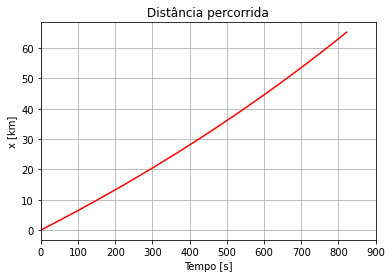

In [ ]:
print('Percorreu-se a distância de ', res_x[-1]/1000, 'km em ', res_t[-1], 'segundos')
plt.plot(res_t, res_x/1000, c='r')
plt.title('Distância percorrida')
plt.grid()
plt.xlim([0, 900])
plt.ylabel('x [km]')
plt.xlabel('Tempo [s]')
plt.show()

Além disso, a aeronave perde cerca de 7% de seu combustível nessa etapa, variando em 1800N seu peso total.

A variação de peso é de  1816.7161890034477 N, correspondendo a  6.9340312557383506 % de uso de combustível nessa etapa


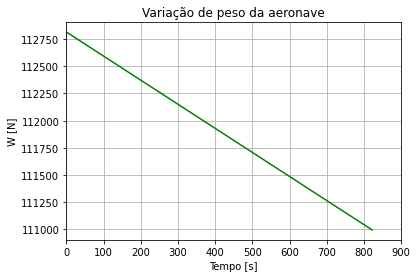

In [ ]:
print('A variação de peso é de ', res_w[0] - res_w[-1], 'N, correspondendo a ', (res_w[0] - res_w[-1]) / w_fuel_total * 100, '% de uso de combustível nessa etapa')
plt.plot(res_t, res_w, c='g')
plt.title('Variação de peso da aeronave')
plt.grid()
plt.xlim([0, 900])
plt.ylabel('W [N]')
plt.xlabel('Tempo [s]')
plt.show()

Já na etapa de voo de cruzeiro, a aeronave atinge o range máximo de 1750km após cerca de 180 minutos (linha pontilhada). Além disso, nota-se que a aeronave consegue ainda voar por 45 minutos de acordo com as reservas NBAA.

O alcance total é de  2168.5888056617355 km após manter velocidade de cruzeiro por 45 minutos além do range máximo


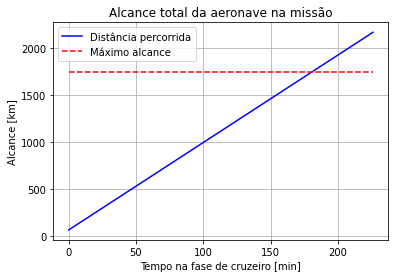

In [ ]:
print('O alcance total é de ', res_x_cruz[-1]/1000, 'km após manter velocidade de cruzeiro por 45 minutos além do range máximo')
plt.plot(res_t_cruz/60, res_x_cruz/1000, c='b')
plt.plot([0, res_t_cruz[-1]/60], [1750, 1750], ls = '--', c='r')
plt.title('Alcance total da aeronave na missão')
plt.legend(['Distância percorrida', 'Máximo alcance'], loc='best')
plt.grid()
# plt.xlim([0, 250])
plt.ylabel('Alcance [km]')
plt.xlabel('Tempo na fase de cruzeiro [min]')
plt.show()

Por fim, o consumo de combustível da aeronave é tal que, ao fim do hold de 45 minutos, sobram cerca de 0.7% de combustível no tanque da aeronave. Com isso, considera-se que o código está validado por conseguir replicar a missão de cruzeiro da aeronave com sobra mínima de combustível.

Ao fim do hold, sobram  0.6852898546721153 % de combustível nos tanques da aeronave


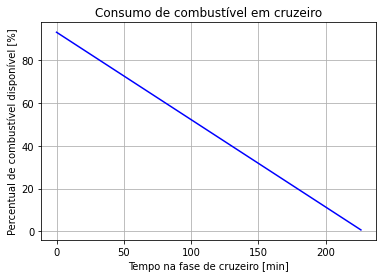

In [ ]:
print('Ao fim do hold, sobram ', res_fuel_cruz[-1]*100, '% de combustível nos tanques da aeronave')
plt.plot(res_t_cruz/60, res_fuel_cruz*100, c='b')
plt.title('Consumo de combustível em cruzeiro')
plt.grid()
plt.ylabel('Percentual de combustível disponível [%]')
plt.xlabel('Tempo na fase de cruzeiro [min]')
plt.show()

# Missão no aeroporto de Leh

Com o código validado, objetiva-se realizar uma missão de alcance 1200km a partir do aeroporto de Leh, na Índia. As condições atmosféricas são de ISA+15° e é necessário considerar reservas NBAA para hold de 45 minutos em velocidade de cruzeiro. De acordo com [Wikipedia](https://en.wikipedia.org/wiki/Kushok_Bakula_Rimpochee_Airport), o aeroporto de Leh está a 10682ft de altitude. Com isso, o final do 4° segmento é dado na altitude de 12182ft, de onde inicia-se a subida até a altitude de serviço de 29500ft.

In [ ]:
"""
Inicialização de variáveis para voo ascendente
"""
cd0 = 0.032
k = 0.021 
W = 11500 * 9.81 
Sw = 39.4  
num_motors = 2
power_each = 1340000
h_initial = 10682 + 1500 #ft
h_goal = 29500 #ft
delta_t = 1 #s
delta_ISA = +15 #°C

#calcular voo ascendente
res_h, res_x, res_t, res_h_ponto, res_gamma, res_w = voo_ascendente(h_initial, h_goal, delta_t, delta_ISA, W)

Analisando a distância percorrida nessa etapa, nota-se que cerca de 47 km foram percorridos. 

Percorreu-se a distância de  47.39081721962278 km em  535.0 segundos


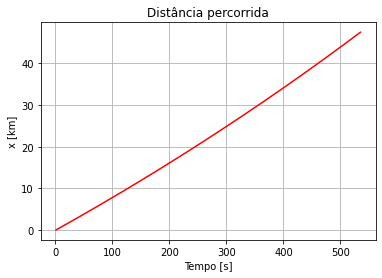

In [ ]:
print('Percorreu-se a distância de ', res_x[-1]/1000, 'km em ', res_t[-1], 'segundos')
plt.plot(res_t, res_x/1000, c='r')
plt.title('Distância percorrida')
plt.grid()
plt.ylabel('x [km]')
plt.xlabel('Tempo [s]')
plt.show()

Além disso, a evolução de altitude no tempo é dada a seguir.

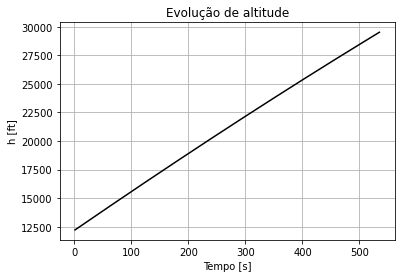

In [ ]:
plt.plot(res_t, res_h, c='k')
plt.title('Evolução de altitude')
plt.grid()
plt.ylabel('h [ft]')
plt.xlabel('Tempo [s]')
plt.show()

Com isso, inicia-se a análise para condição de voo em cruzeiro

In [ ]:
"""
Inicialização de variáveis para voo em cruzeiro
"""

x_goal = 1200e+3 #m
x = res_x[-1] #m
w = res_w[-1] #N
w_fuel_total = 26200 
power_each = 1080000
v = 155

#calcular voo em cruzeiro
res_x_cruz, res_t_cruz, res_w_cruz, res_fuel_cruz = voo_cruzeiro(h_goal, x_goal, x, W, w, w_fuel_total, delta_t, num_motors, power_each, v)

Analisando a distância percorrida, nota-se que em 125 minutos de cruzeiro, a aeronave consegue atingir o alcance desejado de 1200km. Além disso, até 170 minutos ela continua voando, totalizando um alcance de 1620km com as reservas NBAA. 

O alcance total é de  1618.6258172196228 km após manter velocidade de cruzeiro por 45 minutos além do range máximo


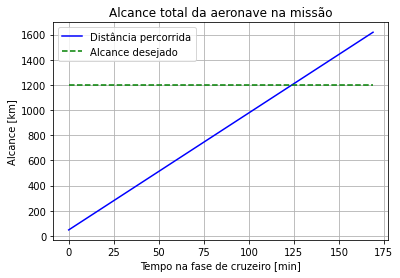

In [ ]:
print('O alcance total é de ', res_x_cruz[-1]/1000, 'km após manter velocidade de cruzeiro por 45 minutos além do range máximo')
plt.plot(res_t_cruz/60, res_x_cruz/1000, c='b')
plt.plot([0, res_t_cruz[-1]/60], [1200, 1200], ls = '--', c='g')
plt.title('Alcance total da aeronave na missão')
plt.legend(['Distância percorrida', 'Alcance desejado'], loc='best')
plt.grid()
# plt.xlim([0, 250])
plt.ylabel('Alcance [km]')
plt.xlabel('Tempo na fase de cruzeiro [min]')
plt.show()

Por fim, a aeronave termina a missão com mais de 25% do tanque cheio. Isso representa que, para cumprimento da missão, a aeronave poderia ter decolado com menos combustível, o que por sua vez geraria menos consumo a cada instante e por meio de um processo iterativo é possível descobrir qual o valor de combustível a aeronave poderia ter decolado para terminar o hold de 45 minutos com mínimo combustível possível.

Ao fim do hold, sobram  26.477990224975684 % de combustível nos tanques da aeronave


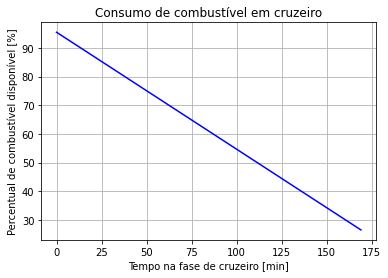

In [ ]:
print('Ao fim do hold, sobram ', res_fuel_cruz[-1]*100, '% de combustível nos tanques da aeronave')
plt.plot(res_t_cruz/60, res_fuel_cruz*100, c='b')
plt.title('Consumo de combustível em cruzeiro')
plt.grid()
plt.ylabel('Percentual de combustível disponível [%]')
plt.xlabel('Tempo na fase de cruzeiro [min]')
plt.show()